# General E(2)-Equivariant Steerable CNNs  -  A concrete example


In [1]:
import os
import csv
import time
import random
from tqdm import tqdm

import numpy as np
from PIL import Image
import cv2

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.transforms import RandomRotation, Pad, Resize, ToTensor, Compose
from torchsummary import summary

from e2cnn import gspaces
from e2cnn import nn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Finally, we build a **Steerable CNN** and try it MNIST.

Let's also use a group a bit larger: we now build a model equivariant to $8$ rotations.
We indicate the group of $N$ discrete rotations as $C_N$, i.e. the **cyclic group** of order $N$.
In this case, we will use $C_8$.

Because the inputs are still gray-scale images, the input type of the model is again a *scalar field*.

However, internally we use *regular fields*: this is equivalent to a *group-equivariant convolutional neural network*.

Finally, we build *invariant* features for the final classification task by pooling over the group using *Group Pooling*.

The final classification is performed by a two fully connected layers.

# The model

Here is the definition of our model:

In [2]:
class C8SteerableCNN(torch.nn.Module):
    
    def __init__(self, n_classes=10, cyclic_group=8):
        self.cyclic_group=cyclic_group
        
        super(C8SteerableCNN, self).__init__()
        
        # the model is equivariant under rotations by 45 degrees, modelled by C8
        self.r2_act = gspaces.Rot2dOnR2(N=self.cyclic_group)
        #print("self.r2_act", self.r2_act)
        
        # the input image is a scalar field, corresponding to the trivial representation
        in_type = nn.FieldType(self.r2_act, 3*[self.r2_act.trivial_repr])
        #print("in_type", in_type)
        
        # we store the input type for wrapping the images into a geometric tensor during the forward pass
        self.input_type = in_type
        
        # convolution 1
        # first specify the output type of the convolutional layer
        # we choose 24 feature fields, each transforming under the regular representation of C8
        out_type = nn.FieldType(self.r2_act, 24*[self.r2_act.regular_repr])
        #print("out_type", out_type)
        self.block1 = nn.SequentialModule(
            nn.MaskModule(in_type, 80, margin=1),
            nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        print('block1', self.block1.out_type.size)
        
        # convolution 2
        # the old output type is the input type to the next layer
        in_type = self.block1.out_type
        # the output type of the second convolution layer are 48 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block2 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        print('block2', self.block2.out_type.size)
        self.pool1 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )
        print('pool1', self.pool1.out_type.size)
        
        # convolution 3
        # the old output type is the input type to the next layer
        in_type = self.block2.out_type
        # the output type of the third convolution layer are 48 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block3 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        print('block3', self.block3.out_type.size)
        
        # convolution 4
        # the old output type is the input type to the next layer
        in_type = self.block3.out_type
        # the output type of the fourth convolution layer are 96 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 96*[self.r2_act.regular_repr])
        self.block4 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        print('block4', self.block4.out_type.size)
        self.pool2 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )
        print('pool2', self.pool2.out_type.size)
        
        # convolution 5
        # the old output type is the input type to the next layer
        in_type = self.block4.out_type
        # the output type of the fifth convolution layer are 96 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 96*[self.r2_act.regular_repr])
        self.block5 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        print('block5', self.block5.out_type.size)
        
        # convolution 6
        # the old output type is the input type to the next layer
        in_type = self.block5.out_type
        # the output type of the sixth convolution layer are 64 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 64*[self.r2_act.regular_repr])
        self.block6 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=1, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        print('block6', self.block6.out_type.size)
        self.pool3 = nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=1, padding=0)
        print('pool3', self.pool3.out_type.size)
        
        self.gpool = nn.GroupPooling(out_type) # pool3.out_type
        
        # number of output channels
        c = self.gpool.out_type.size
        print('gpool', c)
        
        # Fully Connected
        self.fully_net = torch.nn.Sequential(
            torch.nn.Linear(c*13*13, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ELU(inplace=True),
            torch.nn.Linear(64, n_classes),
        )
    
    def forward(self, input: torch.Tensor):
        # wrap the input tensor in a GeometricTensor
        # (associate it with the input type)
        #print("input.shape", input.shape)
        x = nn.GeometricTensor(input, self.input_type)
        
        # apply each equivariant block
        
        # Each layer has an input and an output type
        # A layer takes a GeometricTensor in input.
        # This tensor needs to be associated with the same representation of the layer's input type
        #
        # The Layer outputs a new GeometricTensor, associated with the layer's output type.
        # As a result, consecutive layers need to have matching input/output types
        x = self.block1(x)
        x = self.block2(x)
        x = self.pool1(x)
        
        x = self.block3(x)
        x = self.block4(x)
        x = self.pool2(x)
        
        x = self.block5(x)
        x = self.block6(x)
        
        # pool over the spatial dimensions
        x = self.pool3(x)
        #print("x.shape1", x.shape)
        
        # pool over the group
        x = self.gpool(x)
        #print("x.shape2", x.shape)

        # unwrap the output GeometricTensor
        # (take the Pytorch tensor and discard the associated representation)
        x = x.tensor
        #print("x.shape3", x.shape)
        
        # classify with the final fully connected layers)
        x = self.fully_net(x.reshape(x.shape[0], -1))
        
        return x

In [3]:
# Not rotationally-equivariant architecture, mimics above as closely as possible
class NonRECNN(torch.nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        
        # convolution 1
        self.block1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=24, kernel_size=7, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm2d(num_features=24),
            torch.nn.ReLU(inplace=True)
        )
        
        # convolution 2
        self.block2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=24, out_channels=48, kernel_size=5, stride=1, padding=2, bias=False),
            torch.nn.BatchNorm2d(num_features=48),
            torch.nn.ReLU(inplace=True)
        )
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        # convolution 3
        self.block3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=48, out_channels=48, kernel_size=5, stride=1, padding=2, bias=False),
            torch.nn.BatchNorm2d(num_features=48),
            torch.nn.ReLU(inplace=True)
        )
        
        # convolution 4
        self.block4 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=48, out_channels=96, kernel_size=5, stride=1, padding=2, bias=False),
            torch.nn.BatchNorm2d(num_features=96),
            torch.nn.ReLU(inplace=True)
        )
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        # convolution 5
        self.block5 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=96, out_channels=96, kernel_size=5, stride=1, padding=2, bias=False),
            torch.nn.BatchNorm2d(num_features=96),
            torch.nn.ReLU(inplace=True)
        )
        
        # convolution 6
        self.block6 = torch.nn.Sequential(
            # NOTE 1: changed padding=1 to padding=0 in this layer to help match input size of fc layer
            torch.nn.Conv2d(in_channels=96, out_channels=64, kernel_size=5, stride=1, padding=0, bias=False),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(inplace=True)
        )
        self.pool3 = torch.nn.AvgPool2d(kernel_size=2, stride=1, padding=0)
        # NOTE 2: added another avgpool2d to match input size of fc layer
        self.pool4 = torch.nn.AvgPool2d(kernel_size=2, stride=1, padding=0)
#        self.pool5 = torch.nn.AvgPool2d(kernel_size=2, stride=1, padding=0)
#        self.pool6 = torch.nn.AvgPool2d(kernel_size=2, stride=1, padding=0)

        # Fully Connected
        self.fully_net = torch.nn.Sequential(
            torch.nn.Linear(64*13*13, 64),
            torch.nn.BatchNorm1d(num_features=64),
            torch.nn.ELU(inplace=True),
            torch.nn.Linear(64, n_classes),
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.pool1(x)
        
        x = self.block3(x)
        x = self.block4(x)
        x = self.pool2(x)
        
        x = self.block5(x)
        x = self.block6(x)
        x = self.pool3(x)
        x = self.pool4(x)
#        x = self.pool5(x)
#        x = self.pool6(x)
        
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        
        # classify with the final fully connected layers)
        x = self.fully_net(x.reshape(x.shape[0], -1))
        
        return x

Let's build the model

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
print(device)

cuda


In [15]:
EQUIVARIANT = False
dataname = 'DOTAv1.0'

# 15 for DOTA, 62 for xView
n_classes = -1
if dataname == 'DOTAv1.0':
    n_classes = 15
elif dataname == 'xView':
    n_classes = 62

assert n_classes > 0

In [16]:
if EQUIVARIANT:
    cyclic_group = 8
    model = C8SteerableCNN(n_classes=n_classes, cyclic_group=cyclic_group).to(device)
else:
    cyclic_group = 1
    model = NonRECNN(n_classes=n_classes).to(device)

#summary(model, input_size=(3, 80, 80))

In [6]:
# cyclic_group = 8
# n_classes = 15

# model1 = C8SteerableCNN(n_classes=n_classes, cyclic_group=cyclic_group).to(device)
# summary(model1, input_size=(3, 80, 80))

In [7]:
# model2 = NonRECNN(n_classes=n_classes).to(device)
# summary(model2, input_size=(3, 80, 80))

The model is now randomly initialized. 
Therefore, we do not expect it to produce the right class probabilities.

However, the model should still produce the same output for rotated versions of the same image.
This is true for rotations by multiples of $\frac{\pi}{2}$, but is only approximate for rotations by $\frac{\pi}{4}$.

Let's try the model on *rotated* MNIST

In [8]:
# # download the dataset
# !wget -nc http://www.iro.umontreal.ca/~lisa/icml2007data/mnist_rotation_new.zip
# # uncompress the zip file
# !unzip -n mnist_rotation_new.zip -d mnist_rotation_new

In [9]:
# import requests
# url = 'http://www.iro.umontreal.ca/~lisa/icml2007data/mnist_rotation_new.zip'
# doc = requests.get(url)
# with open('mnistrot.zip', 'wb') as f:
#     f.write(doc.content)

Build the dataset

In [10]:
class TheDataset(Dataset):

    def __init__(self, mode, transform=None, max_num_examples=999999, 
                 chip_size=80, dataname='xView', index_lists={}, classdict={}):
        assert mode in ['train', 'val']
        
        #dataname: DOTAv1.0, xView, FAIR1M, etc
        self.basedir = 'C:/Users/Admin/Desktop/data/'+dataname+'/'
        self.chipdir = self.basedir+"chips_"+mode+"/"

        self.transform = transform
        self.max_num_examples = max_num_examples
        #data = np.loadtxt(self.chipdir, delimiter=' ')
        self.index_lists = index_lists
        self.labels = []
        self.chip_size = chip_size
        self.color = (0,0,0)
        self.classdict = classdict
        self.classval = 0

        for root, dirs, filenames in os.walk(self.chipdir, topdown=False):
            pass

        # first time through, we need to create self.index_lists and self.classdict
        if not self.index_lists:
            # first get all indices of each class and put them into dict self.index_lists
            for d in dirs:
                for root, dirs, filenames in os.walk(self.chipdir+d, topdown=False):
                    pass
                for f in filenames:
                    if self.index_lists.get(d, False):
                        self.index_lists[d].append(int(f[:-4]))
                    else:
                        self.index_lists[d] = [int(f[:-4])]

        # now make self.classdict, or get it from when we made validation data
        if not self.classdict:
            # NOTE: labels must start at 0, not 1, or PyTorch is unhappy
            for k in self.index_lists.keys():
                self.classdict[k] = self.classval
                self.classval += 1

        # now take random sample from each list
        self.images = []
        self.labels = []
        #for k in self.index_lists.keys():
        with tqdm(self.index_lists.keys(), unit="class") as tkeys:
            for k in tkeys:
                ####################################################
                # if too many examples, take self.max_num_examples random examples for that class
                ####################################################
                if len(self.index_lists[k]) > self.max_num_examples:
                    temp = random.sample(self.index_lists[k], self.max_num_examples)

                    for t in temp:
                        self.images.append(self.prep_image(k, t))
                        self.labels.append(classdict[k])
                ####################################################
                # if not enough examples, take all examples of that class
                ####################################################
                else:
                    for t in self.index_lists[k]:
                        self.images.append(self.prep_image(k, t))
                        self.labels.append(classdict[k])
        tkeys.close()


    def prep_image(self, d, f):
        imgstr = self.chipdir+d+"/"+str(f)+".png"
        #print(imgstr)
        #img = Image.open(imgstr)
        #arr = np.asarray(img)
        img = cv2.imread(imgstr)
        old_image_height, old_image_width, channels = img.shape
        #print('old', old_image_height, old_image_width)
        
        # first pad to become a square (then we'll resize later)
        if img.shape[0] < img.shape[1]:
            result1 = np.full((img.shape[1],img.shape[1], channels), self.color, dtype=np.uint8)
            #print('shape', result1.shape)
            # compute center offset
            #x_center = np.abs(self.chip_size - old_image_width) // 2
            y_center = np.abs(img.shape[1] - old_image_height) // 2
            #print('y_center', y_center)
            # copy img image into center of result image
            result1[y_center:y_center+old_image_height, :] = img
        elif img.shape[0] > img.shape[1]:
            result1 = np.full((img.shape[0],img.shape[0], channels), self.color, dtype=np.uint8)
            #print('shape', result1.shape)
            # compute center offset
            x_center = np.abs(img.shape[0] - old_image_width) // 2
            #y_center = np.abs(self.chip_size - old_image_height) // 2
            #print('x_center', x_center)
            # copy img image into center of result image
            result1[:, x_center:x_center+old_image_width] = img
        else:
            result1 = img[:,:,:]
        
        # now resize
        if not (result1.shape[0] == self.chip_size and result1.shape[1] == self.chip_size):
            #print('result1.shape1', result1.shape)
            result1 = cv2.resize(result1, dsize=(self.chip_size, self.chip_size), interpolation=cv2.INTER_CUBIC)
            #print('result1.shape2', result1.shape)
        
        res2 = result1.reshape(-1, self.chip_size, self.chip_size).astype(np.float32) # = arr[:, :-1].reshape(-1, self.chip_size, self.chip_size)
        #print('res2.shape', res2.shape)

        # ToTensor screws up the order, so we have to undo it:
        # https://discuss.pytorch.org/t/torchvision-totensor-dont-change-channel-order/82038/2
        #res2 = res2.permute((1, 2, 0)).contiguous()

        # convert back to PIL Image object for pytorch transforms (e.g. RandomRotation) to work
        #image = Image.fromarray(image)

        #self.images.append(res2)
        
        return res2

#         # labels
#         # NOTE: labels must start at 0, not 1, or PyTorch is unhappy
#         if self.classdict.get(d, -1) >= 0:
#             self.labels.append(self.classdict[d])
#         else: # it's not in self.classdict yet
#             self.classdict[d] = self.classval
#             self.classval += 1

#         if self.max_num_examples > 0:
#             #z1 = list(zip(self.images, self.labels))
#             classdict = {}
#             for i in range(len(self.labels)):
#                 if classdict.get(self.labels[i], False):
#                     classdict[self.labels[i]].append(self.images[i])
#                 else:
#                     classdict[self.labels[i]] = [self.images[i]]
#             self.images = []
#             self.labels = []
#             for i in range(self.classval):
#                 ####################################################
#                 # if too many examples, take self.max_num_examples random examples for that class
#                 ####################################################
#                 if len(classdict[i]) > self.max_num_examples:
#                     temp = random.sample(classdict[i], self.max_num_examples)

#                     for t in temp:
#                         self.images.append(t)
#                         self.labels.append(i)
#                 ####################################################
#                 # if not enough examples, take all examples of that class
#                 ####################################################
#                 else:
#                     for t in classdict[i]:
#                         self.images.append(t)
#                         self.labels.append(i)

        self.num_samples = len(self.labels)
        print("self.num_samples", self.num_samples)


    def __getitem__(self, index):
        image, label = self.images[index], self.labels[index]
        # image is a numpy ndarray instead of PIL Image object
        # NOTE: certain pytorch functions (aka RandomRotate) require PIL Image objects
        # ToTensor screws up the shape/channel order, so we have to undo it:
        # https://discuss.pytorch.org/t/torchvision-totensor-dont-change-channel-order/82038/2
        #image = image.permute((1, 2, 0)).contiguous()
        #image = Image.fromarray(image)
        if self.transform is not None:
            image = self.transform(image)
        return image, label


    def __len__(self):
        return len(self.labels)

# images are padded to have shape 29x29.
# this allows to use odd-size filters with stride 2 when downsampling a feature map in the model
#pad = Pad((0, 0, 1, 1), fill=0)

# to reduce interpolation artifacts (e.g. when testing the model on rotated images),
# we upsample an image by a factor of 3, rotate it and finally downsample it again
#resize1 = Resize(80*3)
#resize2 = Resize(80)

#totensor = ToTensor()

In [11]:
# build the test set
vtest = TheDataset(mode='val', dataname='xView', max_num_examples=1)
print(vtest.index_lists['75'])
print(vtest.classdict)
del vtest

100%|██████████| 62/62 [00:00<00:00, 1093.09class/s]

[121155, 125165, 129605, 130523, 150303, 151274, 151362, 152403, 23194, 588749, 76095]
{'75': 0, '82': 1, 'Aircraft Hangar': 2, 'Barge': 3, 'Building': 4, 'Bus': 5, 'Cargo Car': 6, 'Cargo Plane': 7, 'Cargo Truck': 8, 'Cement Mixer': 9, 'Construction Site': 10, 'Container Crane': 11, 'Container Ship': 12, 'Crane Truck': 13, 'Damaged Building': 14, 'Dump Truck': 15, 'Engineering Vehicle': 16, 'Excavator': 17, 'Facility': 18, 'Ferry': 19, 'Fishing Vessel': 20, 'Fixed-wing Aircraft': 21, 'Flat Car': 22, 'Front loader Bulldozer': 23, 'Ground Grader': 24, 'Haul Truck': 25, 'Helicopter': 26, 'Helipad': 27, 'Hut Tent': 28, 'Locomotive': 29, 'Maritime Vessel': 30, 'Mobile Crane': 31, 'Motorboat': 32, 'Oil Tanker': 33, 'Passenger Car': 34, 'Passenger Vehicle': 35, 'Pickup Truck': 36, 'Pylon': 37, 'Railway Vehicle': 38, 'Reach Stacker': 39, 'Sailboat': 40, 'Scraper Tractor': 41, 'Shed': 42, 'Shipping Container': 43, 'Shipping container lot': 44, 'Small Aircraft': 45, 'Small Car': 46, 'Storage Tan

In [12]:
# retrieve the first image from the test set
#x, y = next(iter(test))
#
#print(x.shape)
#print(test[3530])

In [13]:
def test_model(model: torch.nn.Module, x: Image):
    # evaluate the `model` on 8 rotated versions of the input image `x`
    model.eval()
    totensor = ToTensor()
    
    wrmup = model(torch.randn(1, 3, 80, 80).to(device))
    del wrmup
    
    #x = resize1(pad(x))
    
    print()
    print('##########################################################################################')
    header = 'angle |  ' + '  '.join(["{:6d}".format(d) for d in range(15)])
    print(header)
    with torch.no_grad():
        for r in range(8):
            #print(np.min(x), np.max(x), x.shape)
            intimg = x.astype(np.uint8)
            #print(type(intimg))
            #print(np.min(intimg), np.max(intimg), intimg.shape)
            # go from 3,80,80 -> 80,80,3
            #intimg2 = intimg.permute((1, 2, 0)).contiguous() # can't permute numpy arrays
            intimg2 = intimg.transpose(1, 2, 0)
            #print(np.min(intimg2), np.max(intimg2), intimg2.shape)
            img = Image.fromarray(intimg2)
            #print(np.min(img), np.max(img))
            rotimg = img.rotate(r*45., Image.BILINEAR)
            #print(rotimg.shape)
            x_transformed = totensor(rotimg).reshape(-1, 3, 80, 80)
            x_transformed = x_transformed.to(device)

            y = model(x_transformed)
            y = y.to('cpu').numpy().squeeze()
            
            angle = r * 45
            print("{:3d}:{}".format(angle, y))
    print('##########################################################################################')
    print()

In [14]:
# evaluate the model
#test_model(model, x)

The output of the model is already almost invariant.
However, we still observe small fluctuations in the outputs.

This is because the model contains some operations which might break equivariance.
For instance, every convolution includes a padding of $2$ pixels per side. This is adds information about the actual orientation of the grid where the image/feature map is sampled because the padding is not rotated with the image. 

During training, the model will observe rotated patterns and will learn to ignore the noise coming from the padding.

So, let's train the model now.
The model is exactly the same used to train a normal *PyTorch* architecture:

In [15]:
#dataname: DOTAv1.0, xView, FAIR1M, etc
dataname = 'xView'

In [16]:
# Prep the training dataset
train_transform = Compose([
    #pad,
    #resize1,
    #RandomRotation(180, resample=Image.BILINEAR, expand=False),
    #resize2,
    #ToTensor()
])

#data_train = TheDataset(mode='train', transform=train_transform, dataname=dataname)
#train_loader = torch.utils.data.DataLoader(data_train, batch_size=8, shuffle=True)
#print(len(data_train), len(train_loader))

In [17]:
def get_fresh_training_data(n, index_lists={}, classdict={}):
    data_train = TheDataset(mode='train', transform=train_transform, max_num_examples=n, 
                            chip_size=80, dataname=dataname, index_lists=index_lists, classdict=classdict)
    train_loader = torch.utils.data.DataLoader(data_train, batch_size=8, shuffle=True, drop_last=True)
    #print(len(data_train), len(train_loader))
    return train_loader, data_train.index_lists, data_train.classdict

In [18]:
# Prep the testing dataset
val_transform = Compose([
    #pad,
    #ToTensor()
])

data_val = TheDataset(mode='val', transform=val_transform, 
                      chip_size=80, dataname=dataname)
val_loader = torch.utils.data.DataLoader(data_val, batch_size=8, shuffle=True, drop_last=True)
print(len(data_val), "labels")
print(len(val_loader), "batches")

100%|██████████| 62/62 [01:02<00:00,  1.01s/class]

119881 labels
14985 batches


In [19]:
label_is = []
for v in val_loader:
    label_is.append(v[1])
    break
print(label_is)

[tensor([ 4, 30,  4,  4, 46,  4, 46,  4])]


In [20]:
# mini = 99999
# maxi = 0
# for m in data_train: # data_val
#     if m[1] < mini:
#         mini = m[1]
#     if m[1] > maxi:
#         maxi = m[1]
# print(mini, maxi, "<--- should be 0 14 instead of 1 15")

In [21]:
def save_the_model(model, cyclic_group, epoch, train_acc, train_loss, test_acc, test_loss, dataname):
    if not os.path.exists("models"):
        os.mkdir("models")
    model_name = "models/model_"+dataname+"_C"+str(cyclic_group)+"_"+str(epoch)+"_"+str(round(train_acc,4))+"_"+str(round(train_loss,4))+"_"+str(round(test_acc,4))+"_"+str(round(test_loss,4))+".pth"
#    if not os.path.exists("models/model_"+dataname+".pth"):
    torch.save(model.state_dict(), model_name)
#    print('saved')
#    else:
#         model.load_state_dict(torch.load("models/model_"+dataname+".pth"))
#         print('loaded')

In [22]:
def save_the_results(cyclic_group, epoch, train_accuracy, train_loss, test_accuracy, test_loss, dataname):
    add_headers = False
    if not os.path.exists("results"):
        os.mkdir("results")
    if not os.path.exists("results/model_"+dataname+".csv"):
        add_headers = True
    # writing to csv file
    with open("results/model_"+dataname+".csv", 'a', newline='') as csvfile: 
        # creating a csv writer object 
        csvwriter = csv.writer(csvfile)

        if add_headers:
            csvwriter.writerow(['Dataname', 'Cyclic Group', 'Epoch', 'Train Accuracy', 'Train Loss', 'Test Accuracy', 'Test Loss'])

        # writing the data rows
        csvwriter.writerow([dataname, cyclic_group, epoch, train_accuracy, train_loss, test_accuracy, test_loss])

In [23]:
# Initialize the model
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)

######################################################
# IF CONTINUING TRAINING, LOAD MODEL FROM LAST EPOCH
######################################################
CONTINUING = False
if CONTINUING:
    # train_loader = get_fresh_training_data(30000)
    if EQUIVARIANT:
        model.load_state_dict(torch.load("models/model_dota_C8_65_97.6337_874.7356_84.8987_2469.3884.pth"))
    else:
        model.load_state_dict(torch.load("models/model_dota_C1_64_95.0866_865.1543_86.0953_1910.6196.pth"))

In [24]:
# # get initial performance with random weights
# test_total = 0
# test_correct = 0
# test_loss = 0
# with torch.no_grad():
#     model.eval()
    
#     #for i, (x, t) in enumerate(val_loader):
#     with tqdm(val_loader, unit="batch") as tepoch:
#         for x, t in tepoch:
#             tepoch.set_description(f"Epoch {-1}")
            
#             #if i%1000==0:
#             #    print(i, "/", len(test_loader))

#             x = x.to(device)
#             t = t.to(device)

#             y = model(x)

#             _, prediction = torch.max(y.data, 1)
#             if prediction.shape[0] != t.shape[0]:
#                 print(t)
#                 t = t[:-(t.shape[0]-prediction.shape[0])]
#                 print(t)
#             test_total += t.shape[0]
#             test_correct += (prediction == t).sum().item()

#             loss = loss_function(y, t)
#             test_loss += loss

# test_accuracy = test_correct/test_total*100.
    
# print(f"test accuracy: {test_accuracy}")
# print(f"test loss: {test_loss.item()}")

In [27]:
samples_per_class = 500
max_per_class = 3000
increase_by = 100

index_lists = {}
classdict = data_val.classdict.copy() # so we use the same labels for training later

start_epoch = 0
max_epochs = 100

for epoch in range(start_epoch, max_epochs):
    
    print('starting epoch', epoch)
    
    ########################################
    # TRAIN
    ########################################
    train_total = 0
    train_correct = 0
    train_loss = 0
    model.train()
    
    # NOTE: i pull fresh training data examples each epoch to counter the huge class imbalance.
    #       i keep the validation data the same each epoch though to make sure i'm consistently
    #       measuring validation accuracy/loss.
    train_loader, index_lists, classdict = get_fresh_training_data(samples_per_class,
                                                                   index_lists=index_lists,
                                                                   classdict=classdict)
    print("samples_per_class", samples_per_class)
    # NOTE: increasing the number of samples per class will mess up the loss curve because i am
    #       adding more examples and thus more potential loss each epoch. comment the next line out
    #       if you wish to avoid this.
    if samples_per_class < max_per_class:
        samples_per_class += increase_by

    #for i, (x, t) in enumerate(train_loader):
    with tqdm(train_loader, unit="batch") as tepoch:
        for x, t in tepoch:
            tepoch.set_description(f"Epoch {epoch}")

            #if i%5000==0:
            #    print(i, "/", len(train_loader))

            optimizer.zero_grad()

            x = x.to(device)
            t = t.to(device)

            y = model(x)

            _, prediction = torch.max(y.data, 1)
            # sometimes at the end of an epoch, prediction.shape can be < t.shape
            if prediction.shape[0] != t.shape[0]:
                #print(t)
                t = t[:-(t.shape[0]-prediction.shape[0])]
                #print(t)
            train_total += t.shape[0]
            train_correct += (prediction == t).sum().item()

            loss = loss_function(y, t)
            train_loss += loss

            loss.backward()

            optimizer.step()
    tepoch.close()

    ########################################
    # TEST
    ########################################
    test_total = 0
    test_correct = 0
    test_loss = 0
    
    with torch.no_grad():
        model.eval()
        
        #for i, (x, t) in enumerate(val_loader):
        with tqdm(val_loader, unit="batch") as tepoch:
            for x, t in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                
                #if i%5000==0:
                #    print(i, "/", len(val_loader))

                x = x.to(device)
                t = t.to(device)

                y = model(x)

                _, prediction = torch.max(y.data, 1)
                if prediction.shape[0] != t.shape[0]:
                    #print(t)
                    t = t[:-(t.shape[0]-prediction.shape[0])]
                    #print(t)
                test_total += t.shape[0]
                test_correct += (prediction == t).sum().item()

                loss = loss_function(y, t)
                test_loss += loss

    train_accuracy = train_correct/train_total*100.
    test_accuracy = test_correct/test_total*100.

    #print(f"epoch {epoch} | train accuracy: {train_accuracy}")
    #print(f"epoch {epoch} | train loss: {train_loss.item()}")
    #print(f"epoch {epoch} | test accuracy: {test_accuracy}")
    #print(f"epoch {epoch} | test loss: {test_loss.item()}")

    tepoch.set_postfix({"train_accuracy":train_accuracy, 
                        "train_loss":train_loss.item(),
                        "test_accuracy":test_accuracy,
                        "test_loss":test_loss.item()})
    tepoch.close()
    time.sleep(0.5)
    
    save_the_results(cyclic_group, epoch, train_accuracy, train_loss.item(), test_accuracy, test_loss.item(), dataname)
    save_the_model(model, cyclic_group, epoch, train_accuracy, train_loss.item(), test_accuracy, test_loss.item(), dataname)


starting epoch 25


100%|██████████| 62/62 [00:32<00:00,  1.89class/s]


samples_per_class 3000


Epoch 25: 100%|██████████| 14985/14985 [17:45<00:00, 14.06batch/s] 


starting epoch 26


100%|██████████| 62/62 [00:32<00:00,  1.92class/s]


samples_per_class 3000


Epoch 26: 100%|██████████| 14985/14985 [17:37<00:00, 14.18batch/s]


starting epoch 27


100%|██████████| 62/62 [00:33<00:00,  1.88class/s]


samples_per_class 3000


Epoch 27: 100%|██████████| 14985/14985 [17:39<00:00, 14.14batch/s]


starting epoch 28


100%|██████████| 62/62 [00:33<00:00,  1.87class/s]


samples_per_class 3000


Epoch 28: 100%|██████████| 14985/14985 [17:40<00:00, 14.13batch/s]


starting epoch 29


100%|██████████| 62/62 [00:33<00:00,  1.88class/s]


samples_per_class 3000


Epoch 29: 100%|██████████| 14985/14985 [17:41<00:00, 14.11batch/s]


starting epoch 30


100%|██████████| 62/62 [00:34<00:00,  1.81class/s]


samples_per_class 3000


Epoch 30: 100%|██████████| 14985/14985 [17:40<00:00, 14.13batch/s]


starting epoch 31


100%|██████████| 62/62 [00:34<00:00,  1.82class/s]


samples_per_class 3000


Epoch 31: 100%|██████████| 14985/14985 [17:44<00:00, 14.08batch/s]


starting epoch 32


100%|██████████| 62/62 [00:34<00:00,  1.80class/s]


samples_per_class 3000


Epoch 32: 100%|██████████| 14985/14985 [17:43<00:00, 14.09batch/s]


starting epoch 33


100%|██████████| 62/62 [00:34<00:00,  1.78class/s]


samples_per_class 3000


Epoch 33: 100%|██████████| 14985/14985 [17:47<00:00, 14.04batch/s]


starting epoch 34


100%|██████████| 62/62 [00:34<00:00,  1.80class/s]


samples_per_class 3000


Epoch 34: 100%|██████████| 14985/14985 [17:45<00:00, 14.07batch/s]


starting epoch 35


100%|██████████| 62/62 [00:35<00:00,  1.76class/s]


samples_per_class 3000


Epoch 35: 100%|██████████| 14985/14985 [17:48<00:00, 14.03batch/s]


starting epoch 36


100%|██████████| 62/62 [00:34<00:00,  1.79class/s]


samples_per_class 3000


Epoch 36: 100%|██████████| 14985/14985 [17:45<00:00, 14.06batch/s]


starting epoch 37


100%|██████████| 62/62 [00:35<00:00,  1.75class/s]


samples_per_class 3000


Epoch 37: 100%|██████████| 14985/14985 [17:47<00:00, 14.04batch/s]


starting epoch 38


100%|██████████| 62/62 [00:35<00:00,  1.76class/s]


samples_per_class 3000


Epoch 38: 100%|██████████| 14985/14985 [17:45<00:00, 14.07batch/s]


starting epoch 39


100%|██████████| 62/62 [00:35<00:00,  1.74class/s]


samples_per_class 3000


Epoch 39: 100%|██████████| 14985/14985 [17:49<00:00, 14.01batch/s]


starting epoch 40


100%|██████████| 62/62 [00:36<00:00,  1.70class/s]


samples_per_class 3000


Epoch 40: 100%|██████████| 14985/14985 [17:47<00:00, 14.04batch/s]


starting epoch 41


100%|██████████| 62/62 [00:36<00:00,  1.71class/s]


samples_per_class 3000


Epoch 41: 100%|██████████| 14985/14985 [17:42<00:00, 14.10batch/s]


starting epoch 42


100%|██████████| 62/62 [00:37<00:00,  1.65class/s]


samples_per_class 3000


Epoch 42: 100%|██████████| 14985/14985 [17:47<00:00, 14.03batch/s]


starting epoch 43


100%|██████████| 62/62 [00:37<00:00,  1.64class/s]


samples_per_class 3000


Epoch 43: 100%|██████████| 14985/14985 [17:47<00:00, 14.04batch/s]


starting epoch 44


100%|██████████| 62/62 [00:38<00:00,  1.61class/s]


samples_per_class 3000


Epoch 44: 100%|██████████| 14985/14985 [17:51<00:00, 13.99batch/s]


starting epoch 45


100%|██████████| 62/62 [00:38<00:00,  1.60class/s]


samples_per_class 3000


Epoch 45: 100%|██████████| 14985/14985 [17:53<00:00, 13.96batch/s]


starting epoch 46


100%|██████████| 62/62 [00:39<00:00,  1.58class/s]


samples_per_class 3000


Epoch 46: 100%|██████████| 14985/14985 [17:49<00:00, 14.01batch/s]


starting epoch 47


100%|██████████| 62/62 [00:39<00:00,  1.56class/s]


samples_per_class 3000


Epoch 47: 100%|██████████| 14985/14985 [17:58<00:00, 13.89batch/s]


starting epoch 48


100%|██████████| 62/62 [00:39<00:00,  1.58class/s]


samples_per_class 3000


Epoch 48: 100%|██████████| 14985/14985 [17:56<00:00, 13.92batch/s]


starting epoch 49


100%|██████████| 62/62 [00:39<00:00,  1.56class/s]


samples_per_class 3000


Epoch 49: 100%|██████████| 14985/14985 [17:59<00:00, 13.88batch/s]


starting epoch 50


100%|██████████| 62/62 [00:39<00:00,  1.56class/s]


samples_per_class 3000


Epoch 50: 100%|██████████| 14985/14985 [17:58<00:00, 13.89batch/s]


starting epoch 51


100%|██████████| 62/62 [00:39<00:00,  1.55class/s]


samples_per_class 3000


Epoch 51: 100%|██████████| 14985/14985 [18:00<00:00, 13.87batch/s]


starting epoch 52


100%|██████████| 62/62 [00:40<00:00,  1.52class/s]


samples_per_class 3000


Epoch 52: 100%|██████████| 14985/14985 [18:00<00:00, 13.87batch/s]


starting epoch 53


100%|██████████| 62/62 [00:40<00:00,  1.52class/s]


samples_per_class 3000


Epoch 53: 100%|██████████| 14985/14985 [18:07<00:00, 13.78batch/s]


starting epoch 54


100%|██████████| 62/62 [00:40<00:00,  1.53class/s]


samples_per_class 3000


Epoch 54: 100%|██████████| 14985/14985 [18:07<00:00, 13.78batch/s] 


starting epoch 55


100%|██████████| 62/62 [00:41<00:00,  1.48class/s]


samples_per_class 3000


Epoch 55: 100%|██████████| 14985/14985 [18:12<00:00, 13.72batch/s]


starting epoch 56


100%|██████████| 62/62 [00:41<00:00,  1.51class/s]


samples_per_class 3000


Epoch 56: 100%|██████████| 14985/14985 [18:11<00:00, 13.72batch/s]


starting epoch 57


100%|██████████| 62/62 [00:41<00:00,  1.48class/s]


samples_per_class 3000


Epoch 57: 100%|██████████| 14985/14985 [18:14<00:00, 13.69batch/s]


starting epoch 58


100%|██████████| 62/62 [00:44<00:00,  1.39class/s]


samples_per_class 3000


Epoch 58: 100%|██████████| 14985/14985 [18:17<00:00, 13.65batch/s]


starting epoch 59


100%|██████████| 62/62 [00:45<00:00,  1.37class/s]


samples_per_class 3000


Epoch 59: 100%|██████████| 14985/14985 [18:07<00:00, 13.78batch/s]


starting epoch 60


100%|██████████| 62/62 [00:45<00:00,  1.37class/s]


samples_per_class 3000


Epoch 60: 100%|██████████| 14985/14985 [18:19<00:00, 13.63batch/s]


starting epoch 61


100%|██████████| 62/62 [00:45<00:00,  1.35class/s]


samples_per_class 3000


Epoch 61: 100%|██████████| 14985/14985 [18:24<00:00, 13.57batch/s]


starting epoch 62


100%|██████████| 62/62 [00:45<00:00,  1.36class/s]


samples_per_class 3000


Epoch 62: 100%|██████████| 14985/14985 [18:31<00:00, 13.48batch/s]


starting epoch 63


100%|██████████| 62/62 [00:46<00:00,  1.33class/s]


samples_per_class 3000


Epoch 63: 100%|██████████| 14985/14985 [18:27<00:00, 13.53batch/s]


starting epoch 64


100%|██████████| 62/62 [00:45<00:00,  1.35class/s]


samples_per_class 3000


Epoch 64: 100%|██████████| 14985/14985 [18:27<00:00, 13.53batch/s]


starting epoch 65


100%|██████████| 62/62 [00:46<00:00,  1.32class/s]


samples_per_class 3000


Epoch 65: 100%|██████████| 14985/14985 [18:29<00:00, 13.51batch/s]


starting epoch 66


100%|██████████| 62/62 [00:46<00:00,  1.33class/s]


samples_per_class 3000


Epoch 66: 100%|██████████| 14985/14985 [18:27<00:00, 13.53batch/s]


starting epoch 67


100%|██████████| 62/62 [00:46<00:00,  1.32class/s]


samples_per_class 3000


Epoch 67: 100%|██████████| 14985/14985 [18:30<00:00, 13.49batch/s]


starting epoch 68


100%|██████████| 62/62 [00:46<00:00,  1.33class/s]


samples_per_class 3000


Epoch 68: 100%|██████████| 14985/14985 [18:32<00:00, 13.46batch/s]


starting epoch 69


100%|██████████| 62/62 [00:47<00:00,  1.31class/s]


samples_per_class 3000


Epoch 69: 100%|██████████| 14985/14985 [18:25<00:00, 13.55batch/s]


starting epoch 70


100%|██████████| 62/62 [00:47<00:00,  1.30class/s]


samples_per_class 3000


Epoch 70: 100%|██████████| 14985/14985 [18:32<00:00, 13.47batch/s]


starting epoch 71


100%|██████████| 62/62 [00:47<00:00,  1.31class/s]


samples_per_class 3000


Epoch 71: 100%|██████████| 14985/14985 [18:31<00:00, 13.48batch/s]


starting epoch 72


100%|██████████| 62/62 [00:47<00:00,  1.29class/s]


samples_per_class 3000


Epoch 72: 100%|██████████| 14985/14985 [18:27<00:00, 13.53batch/s]


starting epoch 73


100%|██████████| 62/62 [00:48<00:00,  1.29class/s]


samples_per_class 3000


Epoch 73: 100%|██████████| 14985/14985 [18:29<00:00, 13.51batch/s]


starting epoch 74


100%|██████████| 62/62 [00:47<00:00,  1.29class/s]


samples_per_class 3000


Epoch 74: 100%|██████████| 14985/14985 [18:33<00:00, 13.46batch/s]


starting epoch 75


100%|██████████| 62/62 [00:49<00:00,  1.26class/s]


samples_per_class 3000


Epoch 75: 100%|██████████| 14985/14985 [18:28<00:00, 13.52batch/s]


starting epoch 76


100%|██████████| 62/62 [00:49<00:00,  1.25class/s]


samples_per_class 3000


Epoch 76: 100%|██████████| 14985/14985 [18:35<00:00, 13.43batch/s]


starting epoch 77


100%|██████████| 62/62 [00:48<00:00,  1.27class/s]


samples_per_class 3000


Epoch 77: 100%|██████████| 14985/14985 [18:34<00:00, 13.45batch/s]


starting epoch 78


100%|██████████| 62/62 [00:49<00:00,  1.26class/s]


samples_per_class 3000


Epoch 78: 100%|██████████| 14985/14985 [18:30<00:00, 13.50batch/s]


starting epoch 79


100%|██████████| 62/62 [00:50<00:00,  1.24class/s]


samples_per_class 3000


Epoch 79: 100%|██████████| 14985/14985 [18:35<00:00, 13.43batch/s]


starting epoch 80


100%|██████████| 62/62 [00:49<00:00,  1.26class/s]


samples_per_class 3000


Epoch 80: 100%|██████████| 14985/14985 [18:36<00:00, 13.42batch/s]


starting epoch 81


100%|██████████| 62/62 [00:50<00:00,  1.24class/s]


samples_per_class 3000


Epoch 81: 100%|██████████| 14985/14985 [1:22:12<00:00,  3.04batch/s]     


starting epoch 82


100%|██████████| 62/62 [01:02<00:00,  1.01s/class]


samples_per_class 3000


Epoch 82: 100%|██████████| 14985/14985 [18:37<00:00, 13.40batch/s]


starting epoch 83


100%|██████████| 62/62 [00:51<00:00,  1.20class/s]


samples_per_class 3000


Epoch 83: 100%|██████████| 14985/14985 [18:34<00:00, 13.45batch/s]


starting epoch 84


100%|██████████| 62/62 [00:51<00:00,  1.21class/s]


samples_per_class 3000


Epoch 84: 100%|██████████| 14985/14985 [18:30<00:00, 13.49batch/s]


starting epoch 85


100%|██████████| 62/62 [00:51<00:00,  1.21class/s]


samples_per_class 3000


Epoch 85: 100%|██████████| 14985/14985 [18:41<00:00, 13.36batch/s]


starting epoch 86


100%|██████████| 62/62 [00:51<00:00,  1.20class/s]


samples_per_class 3000


Epoch 86: 100%|██████████| 14985/14985 [18:38<00:00, 13.39batch/s]


starting epoch 87


100%|██████████| 62/62 [00:51<00:00,  1.21class/s]


samples_per_class 3000


Epoch 87: 100%|██████████| 14985/14985 [18:49<00:00, 13.26batch/s]


starting epoch 88


100%|██████████| 62/62 [00:55<00:00,  1.12class/s]


samples_per_class 3000


Epoch 88: 100%|██████████| 14985/14985 [18:44<00:00, 13.33batch/s]


starting epoch 89


100%|██████████| 62/62 [00:50<00:00,  1.22class/s]


samples_per_class 3000


Epoch 89: 100%|██████████| 14985/14985 [18:43<00:00, 13.34batch/s]


starting epoch 90


100%|██████████| 62/62 [00:50<00:00,  1.22class/s]


samples_per_class 3000


Epoch 90: 100%|██████████| 14985/14985 [18:45<00:00, 13.31batch/s]


starting epoch 91


100%|██████████| 62/62 [00:50<00:00,  1.22class/s]


samples_per_class 3000


Epoch 91: 100%|██████████| 14985/14985 [18:46<00:00, 13.31batch/s]


starting epoch 92


100%|██████████| 62/62 [00:52<00:00,  1.19class/s]


samples_per_class 3000


Epoch 92: 100%|██████████| 14985/14985 [18:40<00:00, 13.38batch/s]


starting epoch 93


100%|██████████| 62/62 [00:51<00:00,  1.21class/s]


samples_per_class 3000


Epoch 93: 100%|██████████| 14985/14985 [18:46<00:00, 13.31batch/s]


starting epoch 94


100%|██████████| 62/62 [00:51<00:00,  1.20class/s]


samples_per_class 3000


Epoch 94: 100%|██████████| 14985/14985 [18:41<00:00, 13.37batch/s]


starting epoch 95


100%|██████████| 62/62 [00:52<00:00,  1.18class/s]


samples_per_class 3000


Epoch 95: 100%|██████████| 14985/14985 [18:39<00:00, 13.38batch/s]


starting epoch 96


100%|██████████| 62/62 [00:51<00:00,  1.21class/s]


samples_per_class 3000


Epoch 96: 100%|██████████| 14985/14985 [18:42<00:00, 13.35batch/s]


starting epoch 97


100%|██████████| 62/62 [00:50<00:00,  1.22class/s]


samples_per_class 3000


Epoch 97: 100%|██████████| 14985/14985 [18:43<00:00, 13.33batch/s]


starting epoch 98


100%|██████████| 62/62 [00:52<00:00,  1.17class/s]


samples_per_class 3000


Epoch 98: 100%|██████████| 14985/14985 [18:45<00:00, 13.32batch/s]


starting epoch 99


100%|██████████| 62/62 [00:51<00:00,  1.21class/s]


samples_per_class 3000


Epoch 99: 100%|██████████| 14985/14985 [18:49<00:00, 13.27batch/s]


In [28]:
# save_the_results(cyclic_group, epoch, train_accuracy, train_loss.item(), test_accuracy, test_loss.item(), dataname)
# save_the_model(model, cyclic_group, epoch, train_accuracy, train_loss.item(), test_accuracy, test_loss.item(), dataname)

In [29]:
# train_accuracy = train_correct/train_total*100.
# print(train_correct, train_total, train_accuracy)
#save_the_results(cyclic_group, epoch, train_accuracy, train_loss.item(), test_accuracy, test_loss.item())
#save_the_model(model, cyclic_group, epoch, train_accuracy, train_loss.item(), test_accuracy, test_loss.item())

In [30]:
# print(prediction.shape, t.shape)
# print(prediction)
# print(t)
# print(t[:-1])
# print(y.shape)
# print(torch.max(y.data, 1)) # 1 is the dimension

In [31]:
# epoch -1 | test accuracy: 10.011096469935502
# epoch -1 | test loss: 2109988.5

# epoch 0 | train accuracy: 52.91684784257414
# epoch 0 | train loss: 42925.43359375
# epoch 0 | test accuracy: 18.846660656078782
# epoch 0 | test loss: 201328.765625

In [32]:
#data_test = TheDataset(mode='test', dataname=dataname)

In [33]:
# retrieve the first image from the test set
x, y = next(iter(data_val))

# evaluate the model
test_model(model, x)


##########################################################################################
angle |       0       1       2       3       4       5       6       7       8       9      10      11      12      13      14
  0:[ -3.1454  -4.0015  -2.7524  -2.8747   2.268   -3.7672  -5.7331  -2.3572  -3.4632  -5.0219   4.8337  -2.8381   3.3266  -8.311   -5.5774  -7.1562  -8.4448  -6.6916   0.3418  -6.5449  -8.6987 -10.9164
  -6.5281  -6.2351  -7.9325   1.0007 -12.1102  -9.1635 -11.7663 -11.3258  -3.3917  -4.5088  -8.0938  -0.078   -2.6732  -2.6682  -4.1058  -7.8122  -3.7439 -11.6543 -11.6646  -6.7615  -1.8079  -2.4354
   8.1308 -12.4295   2.3163  -1.3611  -8.6112 -10.6518  -9.8802  -1.0802   1.656    1.2707  -4.9756  -3.1231  -7.518  -10.4124 -10.2725  -3.4223   3.4528  -6.4931]
 45:[ -3.2861  -3.2909  -2.7522  -3.3987   2.2829  -3.8788  -5.9907  -2.1532  -3.058   -5.3947   4.9027  -2.5717   3.2171  -8.0521  -6.1488  -7.2831  -8.6573  -7.1848   0.3348  -7.4199  -8.8396 -10.2773
  -6.344   

In [34]:
n_classes = 62 # 15

confusion_matrix = torch.zeros(n_classes, n_classes)
with torch.no_grad():
#     for i, (x, t) in enumerate(val_loader):
#         if i%1000==0:
#             print(i, "/", len(val_loader))
    with tqdm(val_loader, unit="batch") as tepoch:
        for x, t in tepoch:
            x = x.to(device)
            t = t.to(device)
            y = model(x)
            _, preds = torch.max(y, 1)
            for t2, p in zip(t.view(-1), preds.view(-1)):
                confusion_matrix[t2.long(), p.long()] += 1

100%|██████████| 14985/14985 [17:45<00:00, 14.07batch/s]


In [35]:
print(confusion_matrix)

tensor([[  0.,   0.,   0.,  ...,   0.,   3.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   1.,   0.],
        [  0.,   0.,   3.,  ...,   0.,   1.,   0.],
        ...,
        [  0.,   0.,   0.,  ...,  77.,   3.,   0.],
        [  1.,   0.,   0.,  ...,   5., 400.,   6.],
        [  0.,   0.,   0.,  ...,   0.,   9.,  35.]])


In [36]:
import sys
np.set_printoptions(threshold=sys.maxsize)
cm = confusion_matrix.numpy().copy()
cm = cm.astype('int32')
print(cm)

[[    0     0     0     0     4     0     0     0     0     0     0     0     1     0     1     0     0     0     1     0     0     0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     1     0     0     0     0     3     0]
 [    0     0     0     0     2     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     1     0]
 [    0     0     3     0    27     0     0     1     0     0     2     0     0     0     1     0     0     0     1     0     0     0     0     0     0     0     0     0     0     0     0     0     0
      0     1     0     0     0     0     0   

In [37]:
for root, dirs, filenames in os.walk(data_val.chipdir, topdown=False):
    pass
print(dirs)

['75', '82', 'Aircraft Hangar', 'Barge', 'Building', 'Bus', 'Cargo Car', 'Cargo Plane', 'Cargo Truck', 'Cement Mixer', 'Construction Site', 'Container Crane', 'Container Ship', 'Crane Truck', 'Damaged Building', 'Dump Truck', 'Engineering Vehicle', 'Excavator', 'Facility', 'Ferry', 'Fishing Vessel', 'Fixed-wing Aircraft', 'Flat Car', 'Front loader Bulldozer', 'Ground Grader', 'Haul Truck', 'Helicopter', 'Helipad', 'Hut Tent', 'Locomotive', 'Maritime Vessel', 'Mobile Crane', 'Motorboat', 'Oil Tanker', 'Passenger Car', 'Passenger Vehicle', 'Pickup Truck', 'Pylon', 'Railway Vehicle', 'Reach Stacker', 'Sailboat', 'Scraper Tractor', 'Shed', 'Shipping Container', 'Shipping container lot', 'Small Aircraft', 'Small Car', 'Storage Tank', 'Straddle Carrier', 'Tank car', 'Tower', 'Tower crane', 'Trailer', 'Truck', 'Truck Tractor', 'Truck w Box', 'Truck w Flatbed', 'Truck w Liquid', 'Tugboat', 'Utility Truck', 'Vehicle Lot', 'Yacht']


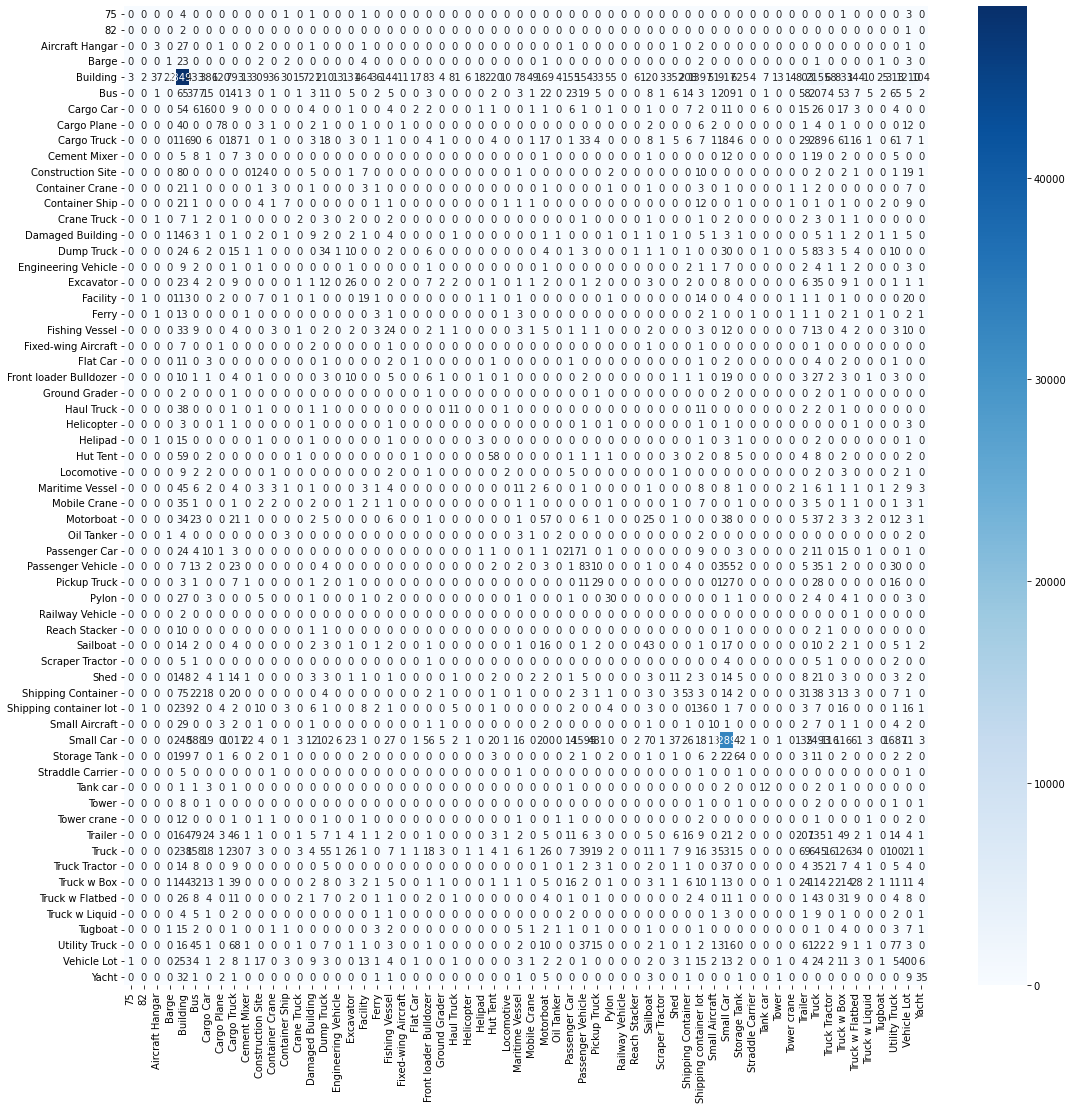

In [38]:
if EQUIVARIANT:
    cnum = "8"
else:
    cnum = "1"

dfcm = pd.DataFrame(cm,
                    index = dirs,
                    columns=dirs)
plt.figure(figsize = (18,18))
sns.heatmap(dfcm, annot=True, cmap="Blues", fmt='d')
plt.savefig("results/c"+cnum+"_confusion_matrix_"+dataname+"_counts.png",
            dpi=100,
            bbox_inches='tight')

In [39]:
print(100*confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([ 0.0000,  0.0000,  7.5000,  2.5000, 77.0471, 27.7206, 46.2428, 50.3226,
        15.8340,  4.6154, 48.4375,  6.1224, 10.6061,  6.0606,  4.3689, 13.3333,
         0.0000, 15.6627,  9.9476,  8.1081, 15.6863,  0.0000,  3.3333,  5.6075,
         0.0000, 15.7143,  0.0000, 10.0000, 36.4780,  6.0606,  7.9710,  1.3333,
        19.6552, 11.1111, 70.6840, 14.1880, 12.7753, 34.4828,  0.0000,  0.0000,
        32.0896,  0.0000,  4.1199, 16.3077, 28.2158, 14.2857, 77.9566, 18.7134,
         0.0000, 50.0000,  0.0000,  0.0000, 24.4970, 26.0396, 12.6506, 29.4360,
         4.8387,  0.0000,  0.0000, 10.2258, 48.4262, 37.2340])


In [40]:
cm2 = confusion_matrix.numpy().copy()
#cm2 = cm2.astype('int32')
print(cm2)

[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 4.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+

In [41]:
print(confusion_matrix.sum(1))

tensor([1.1000e+01, 3.0000e+00, 4.0000e+01, 4.0000e+01, 6.2942e+04, 1.3600e+03,
        3.4600e+02, 1.5500e+02, 1.1810e+03, 6.5000e+01, 2.5600e+02, 4.9000e+01,
        6.6000e+01, 3.3000e+01, 2.0600e+02, 2.5500e+02, 4.0000e+01, 1.6600e+02,
        1.9100e+02, 3.7000e+01, 1.5300e+02, 1.4000e+01, 3.0000e+01, 1.0700e+02,
        1.0000e+01, 7.0000e+01, 1.5000e+01, 3.0000e+01, 1.5900e+02, 3.3000e+01,
        1.3800e+02, 7.5000e+01, 2.9000e+02, 1.8000e+01, 3.0700e+02, 5.8500e+02,
        2.2700e+02, 8.7000e+01, 3.0000e+00, 1.6000e+01, 1.3400e+02, 1.9000e+01,
        2.6700e+02, 3.2500e+02, 4.8200e+02, 7.0000e+01, 4.2194e+04, 3.4200e+02,
        1.0000e+01, 2.4000e+01, 1.5000e+01, 2.6000e+01, 8.4500e+02, 2.4770e+03,
        1.6600e+02, 7.2700e+02, 1.8600e+02, 3.4000e+01, 5.5000e+01, 7.5300e+02,
        8.2600e+02, 9.4000e+01])


In [42]:
for row in range(len(cm2)):
    for col in range(len(cm2[row])):
        cm2[row, col] = (100 * cm2[row, col]) / (confusion_matrix.sum(1)[row])

In [43]:
cm2 = cm2.astype('float32') #float32, int32
#cm2 = cm2.astype('int32') #float32, int32
print(cm2)

[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.6364e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 9.0909e+00 0.0000e+00 9.0909e+00 0.0000e+00 0.0000e+00 0.0000e+00
  9.0909e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 9.0909e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.7273e+01 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 6.6667e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+

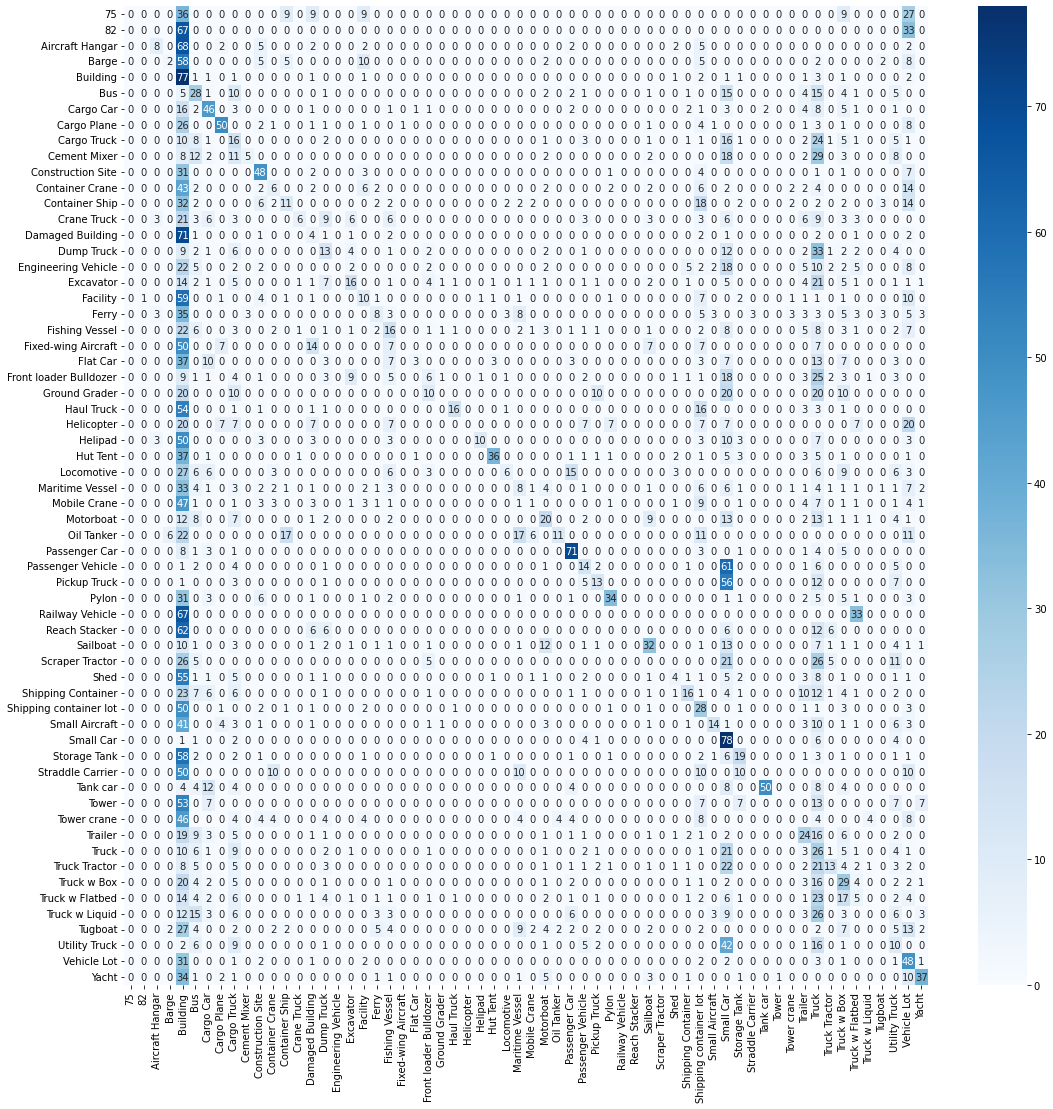

In [44]:
if EQUIVARIANT:
    cnum = "8"
else:
    cnum = "1"

dfcm2 = pd.DataFrame(cm2,
                    index = dirs,
                    columns=dirs)
plt.figure(figsize = (18,18))
sns.heatmap(dfcm2, annot=True, cmap="Blues", fmt='.0f') # , fmt='.1f' 'd' 'g'
plt.savefig("results/c"+cnum+"_confusion_matrix_"+dataname+"_accuracies.png",
            dpi=100,
            bbox_inches='tight')